Существенной проблемой при применении моделей машинного обучения в промышленности является опасность сдвига распределения между данными, на которых строилась модель, и реальными данными. Поэтому типичным требованием к моделям в промышленности является способность детектировать данные, с которыми модель не сможет справиться. Покажем, как можно использовать библиотеку eXpain-NNs для решения данной задачи.

Рассмотрим на примере задачи распознавания дефектов при изготовлении импеллеров для погружных насосов.
На картинке приведены изображения нормального импеллера (слева) и импеллера с дефектом (справа):
![impellers](impellers.png)

Обучение модели можно посмотреть в [репозитории](https://github.com/Med-AI-Lab/eXNN-task-casting-defects). Посмотрим, как с помощью построения нейробайесовского аналога построенной модели и оценки неопределенности предсказаний мы сможем отличить чистые данные (на которых модель может сделать предсказание) от испорченных (не пригодных для предсказания). Испорченные данные построим с помощью состязательной FGSM-атаки.

## Определения функций

### Загрузка зависимостей

In [3]:
import os
os.chdir('../..')

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from examples.casting.data import create_datasets
from eXNN.NetBayesianization import BasicBayesianWrapper

### Состязательная атака

In [5]:
def fgsm_attack(model, loss, images, labels, eps, device):
    
    images = images
    labels = labels
    images.requires_grad = True
    
    outputs = model.forward(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

### Сбор предсказаний модели

In [6]:
def _d(t: torch.Tensor): 
    return t.detach().cpu()

In [13]:
def collect_predictions(determ_model, bayes_model, dataset, device):
    simple_res = {"acc": [], "uncert": []}
    corrupted_res = {"acc": [], "uncert": []}

    example_error = None
    max_std = 0

    # collect predictions
    for i, img_data in enumerate(dataset):
        img, cls = img_data[0].to(device).unsqueeze(0), img_data[1]

        # make prediction on original data
        pred = bayes_model.predict(img, n_iter = 10)
        pred_mean, pred_std = _d(pred["mean"]).argmax().item(), _d(pred["std"])
        simple_res["acc"].append(pred_mean == cls)
        simple_res["uncert"].append(pred_std.numpy())

        # make prediction on corrupted data
        corrupted_img = fgsm_attack(determ_model, nn.NLLLoss(), img, 
                            torch.LongTensor([cls]).to(device), eps=0.01, device=device)
        corrupted_pred = bayes_model.predict(corrupted_img, n_iter = 10)
        corrupted_pred_mean, corrupted_pred_std = _d(corrupted_pred["mean"]).argmax().item(), _d(corrupted_pred["std"])
        corrupted_res["acc"].append(corrupted_pred_mean == cls)
        corrupted_res["uncert"].append(corrupted_pred_std.numpy())

        # select example of the erroneous prediction with largest uncertainty for visual analysis
        if corrupted_pred_mean != pred_mean:
            if corrupted_pred_std.mean().item() > max_std:
                max_std = corrupted_pred_std.mean().item()
                example_error = [img.cpu().detach(), corrupted_img.cpu().detach(), 
                                  {i: j.cpu().detach() for i, j in pred.items()},
                                  {i: j.cpu().detach() for i, j in corrupted_pred.items()}]

        if (example_error is not None) and (i > 100):
            break
    
    simple_data = np.array([np.mean(i) for i in simple_res["uncert"]])
    corrupted_data = np.array([np.mean(i) for i in corrupted_res["uncert"]])
    simple_data = simple_data[simple_data < np.percentile(simple_data, 98)]
    corrupted_data = corrupted_data[corrupted_data < np.percentile(corrupted_data, 98)]
    return simple_data, corrupted_data

## Решение задачи

In [9]:
# скачайте repository https://github.com/Med-AI-Lab/eXNN-task-casting-defects
# переопределите ind_repo так чтобы переменная указывала путь к загруженному репозиторию
ind_repo = Path('../eXNN-task-casting-defects')

In [10]:
# подготовка данных
_, test_ds = create_datasets(ind_repo / 'casting_512x512')

In [14]:
# подготовка модели
device = torch.device('cuda:0')
model = torch.load(ind_repo / 'trained_model.pt', map_location=device).eval()
# построим нейробайесовский аналог модели
wrapper_model = BasicBayesianWrapper(model, "beta", p = None, a = 0.6, b = 12.0)

In [15]:
# оценим неопределенность предсказаний на тестовой выборке на чистых и испорченных данных
simple_data, corrupted_data = collect_predictions(model, wrapper_model, test_ds, device)

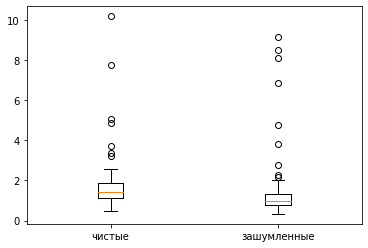

In [19]:
# отобразим статистики неопределенности предсказаний на чистых и испорченных данных
plt.boxplot([simple_data, corrupted_data])
plt.xticks([1, 2], ["чистые", "зашумленные"])
plt.plot();